## O QUE FALTA FAZER


- Trocar os nomes das colunas para os graficos

In [1]:
import pandas as pd
import os
import numpy as np
from google.colab import drive
import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from types import SimpleNamespace

# Carregando dados tratados no colab 3



In [2]:
'''drive.mount('/content/drive')

load_path = '/content/drive/MyDrive/INF 420 - IA/TRABALHO FINAL/dados_processados/'


with open(load_path + 'X_scaled.pkl', 'rb') as f:
    X_scaled = pickle.load(f)

with open(load_path + 'y_encoded.pkl', 'rb') as f:
    y_encoded = pickle.load(f)

with open(load_path + 'label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open(load_path + 'scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open(load_path + 'emopia_features_with_labels.pkl', 'rb') as f:
    features_df = pickle.load(f)
'''
drive.mount('/content/drive')

load_path = '/content/drive/MyDrive/INF 420 - IA/TRABALHO FINAL/dados_processados/'


with open(load_path + 'X.pkl', 'rb') as f:
    X_scaled = pickle.load(f)

with open(load_path + 'y_encoded.pkl', 'rb') as f:
    y_encoded = pickle.load(f)

with open(load_path + 'label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

'''
with open(load_path + 'scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
'''

with open(load_path + 'emopia_features_with_labels.pkl', 'rb') as f:
    features_df = pickle.load(f)


Mounted at /content/drive


# Funçoes que os modelos irao chamar

In [3]:
def avaliar_modelo(modelo, X, y, cv):
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    resultados = cross_validate(modelo, X, y, cv=cv, scoring=scoring)
    y_pred = cross_val_predict(modelo, X, y, cv=cv)
    cm = confusion_matrix(y, y_pred)
    return resultados, cm

In [4]:
def gerar_tabela_metricas_gerais(resultados, nome_modelo):
    metricas = {
        'Acurácia': resultados['test_accuracy'],
        'Precisão (macro)': resultados['test_precision_macro'],
        'Recall (macro)': resultados['test_recall_macro'],
        'F1 (macro)': resultados['test_f1_macro']
    }

    df_metricas = pd.DataFrame({
        'Média': {k: np.mean(v) for k, v in metricas.items()},
        'Desvio': {k: np.std(v) for k, v in metricas.items()}
    })

    styled_df = (
        df_metricas
        .style
        .format("{:.4f}")
        .background_gradient(cmap='Blues', subset=['Média'])
        .set_caption(f"Métricas Gerais - {nome_modelo}")
    )

    display(styled_df)
    return df_metricas


In [5]:
def gerar_tabela_metricas_por_classe(y_true, y_pred, label_encoder):
    relatorio_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

    df_metricas = pd.DataFrame(relatorio_dict).transpose()

    styled_df = (
        df_metricas
        .style
        .format("{:.2f}")
        .background_gradient(cmap='Blues', subset=pd.IndexSlice[label_encoder.classes_, ['precision', 'recall', 'f1-score']])
        .set_caption("Métricas por Classe")
    )

    display(styled_df)
    return df_metricas

In [6]:
def plotar_metricas_cv(resultados, nome_modelo, y_true, y_pred, label_encoder):
    # ---- MÉTRICAS GERAIS ----
    metricas = {
        'Acurácia': resultados['test_accuracy'],
        'Precisão (macro)': resultados['test_precision_macro'],
        'Recall (macro)': resultados['test_recall_macro'],
        'F1 (macro)': resultados['test_f1_macro']
    }
    medias = {k: np.mean(v) for k, v in metricas.items()}
    desvios = {k: np.std(v) for k, v in metricas.items()}

    # ---- PLOT GERAL ----
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
      x=list(medias.keys()),
      y=list(medias.values()),
      s=100,
      color='royalblue',
      marker='o',
      edgecolor='black'
    )

    # plt.ylim(0.54, 1.0)
    plt.ylim(0.54, 0.80)
    plt.title(f'Métricas de Validação Cruzada (macro) - {nome_modelo}')
    plt.grid(axis='y', linestyle='--', alpha=0.4)

    for i, (k, v) in enumerate(medias.items()):
      plt.text(i, v + 0.02, f"{v:.2f}±{desvios[k]:.2f}", ha='center', fontsize=10)

    plt.show()

    '''# ---- RELATÓRIO POR CLASSE ----
    print(f"\n=== Relatório de Classificação por Classe - {nome_modelo} ===")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    '''

    # ---- ACURÁCIA BALANCEADA ----
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Acurácia Balanceada: {bal_acc:.4f}")
    print("Média aritmética do Recall de cada classe (dados desbalanceados)\n")

    # ---- COHEN'S KAPPA ----
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.\n")


In [7]:
def plotar_matriz_confusao(cm, nome_modelo, labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.show()

# Classificadores

- SVM
- Random Forest
- MLP
- KNN
- Logistic Regression
- Naive Bayes
- Gradient Boosting

In [8]:
# class_weight='balanced' ---->  faz o modelo dar mais “peso” as classes menores durante o treinamento

modelos = {
    'SVM': SVC(class_weight='balanced', kernel='rbf', C=10, gamma='auto', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=250, random_state=42, max_depth=30),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', alpha=0.001, max_iter=1000, learning_rate = 'adaptive', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=14),
    'Logistic Regression': LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.01, max_iter=500, max_depth=10, min_samples_leaf=5, random_state=42)
}


# Escolher o melhor modelo

## Avaliar as métricas

Sabendo que a contagem de músicas por emotion_quadrant é
- Q1  -->  161682
- Q2  -->  220272
- Q3  -->  113168
- Q4  -->  133324

Vamos escolher métricas que considerem o desbalanceamento dos dados (pois Q2 tem quase o dobro de amostras que Q3)

1. Matriz de confusao

Mostra a distribuição dos erros por classe (identifica se o modelo está enviesado para a classe majoritária Q2)

2. Precision, Recall e F1-Score por classe

F1-Score é especialmente útil para dados desbalanceados

3. Acurácia Balanceada

Calcula a média aritmética do Recall de cada classe, evitando viés pela classe majoritária

4. Cohen's Kappa

Mede a concordância entre previsões e labels, ajustando para acertos aleatórios.

Valores próximos de 1 indicam bom desempenho.

# Validação Cruzada

10 Fold

In [9]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Testar os hiperparametros

In [ ]:
'''
modelos = {
}


for nome, modelo in modelos.items():
    print(f"=== {nome} ===")
    resultados = cross_validate(modelo, X_scaled, y_encoded, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    y_pred = cross_val_predict(modelo, X_scaled, y_encoded, cv=cv)
    cm = confusion_matrix(y_encoded, y_pred)

    plotar_metricas_cv(resultados, nome, y_encoded, y_pred, label_encoder)
    gerar_tabela_metricas_por_classe(y_encoded, y_pred, label_encoder)
    plotar_matriz_confusao(cm, nome, label_encoder.classes_)
'''

## PLOTAR INDIVIDUAL

Possibilidade de Usar **SMOTE**

- Em datasets desbalanceados, pode levar modelos de Machine Learning a serem viesados em favor da classe majoritaria, resultando em um desempenho ruim na identificação da classe minoritária

- O SMOTE balancear o dataset não apenas duplicando as amostras existentes da classe minoritária, mas sim gerando novas amostras sintéticas para essa classe.

In [10]:
def avaliar_e_plotar(nome, modelo, X, y, cv, label_encoder, usar_smote=False):
    print(f"=== {nome} ===")

    if usar_smote:
        # Envolve o modelo em um pipeline com SMOTE
        pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(random_state=42)),
            ('modelo', modelo)
        ])
    else:
        pipeline = modelo

    resultados = cross_validate(pipeline, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    cm = confusion_matrix(y, y_pred)

    gerar_tabela_metricas_gerais(resultados, nome)
    plotar_metricas_cv(resultados, nome, y, y_pred, label_encoder)
    gerar_tabela_metricas_por_classe(y, y_pred, label_encoder)
    plotar_matriz_confusao(cm, nome, label_encoder.classes_)


### SVM

=== SVM ===


,Média,Desvio
Acurácia,0.6439,0.0461
Precisão (macro),0.6439,0.0500
Recall (macro),0.6386,0.0472
F1 (macro),0.6350,0.0497


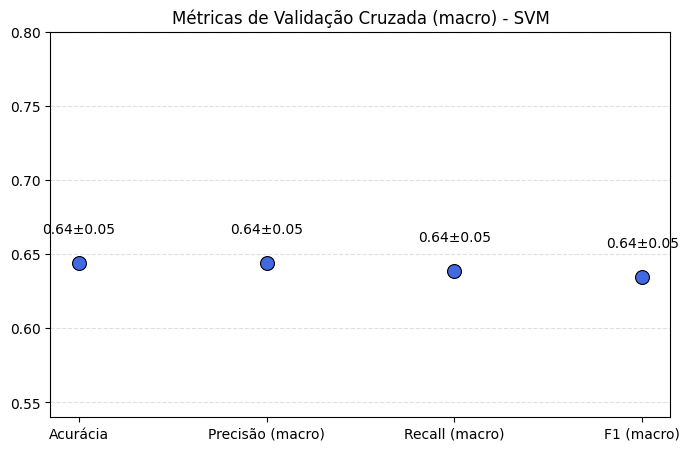

Acurácia Balanceada: 0.6382
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.5227
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.61,0.68,0.65,250.00
Q2,0.70,0.62,0.65,265.00
Q3,0.60,0.50,0.55,253.00
Q4,0.66,0.75,0.70,310.00
accuracy,0.64,0.64,0.64,0.64
macro avg,0.64,0.64,0.64,1078.00
weighted avg,0.64,0.64,0.64,1078.00


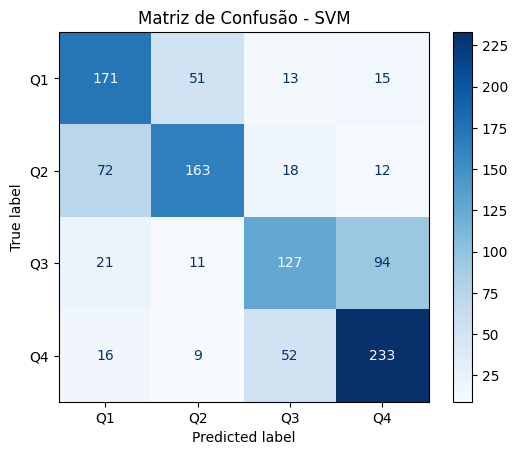

In [11]:
avaliar_e_plotar('SVM', modelos['SVM'], X_scaled, y_encoded, cv, label_encoder)

=== SVM - SMOTE ===


,Média,Desvio
Acurácia,0.6458,0.0451
Precisão (macro),0.6443,0.0471
Recall (macro),0.6416,0.0462
F1 (macro),0.6379,0.0483


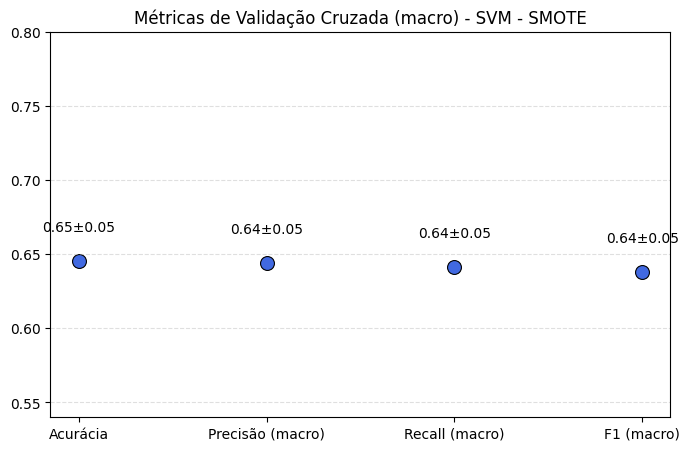

Acurácia Balanceada: 0.6411
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.5256
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.61,0.70,0.65,250.00
Q2,0.69,0.61,0.65,265.00
Q3,0.60,0.52,0.56,253.00
Q4,0.67,0.74,0.70,310.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.64,0.64,0.64,1078.00
weighted avg,0.65,0.65,0.64,1078.00


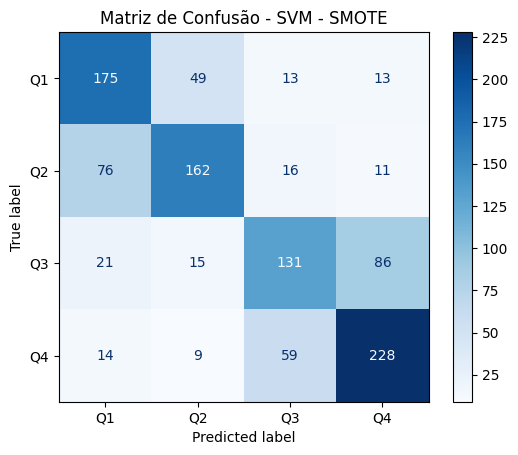

In [12]:
# com SMOTE PARA COMPARAR
avaliar_e_plotar('SVM - SMOTE', modelos['SVM'], X_scaled, y_encoded, cv, label_encoder, True)

### Random Forest

=== Random Forest ===


,Média,Desvio
Acurácia,0.6550,0.0403
Precisão (macro),0.6560,0.0392
Recall (macro),0.6488,0.0397
F1 (macro),0.6466,0.0405


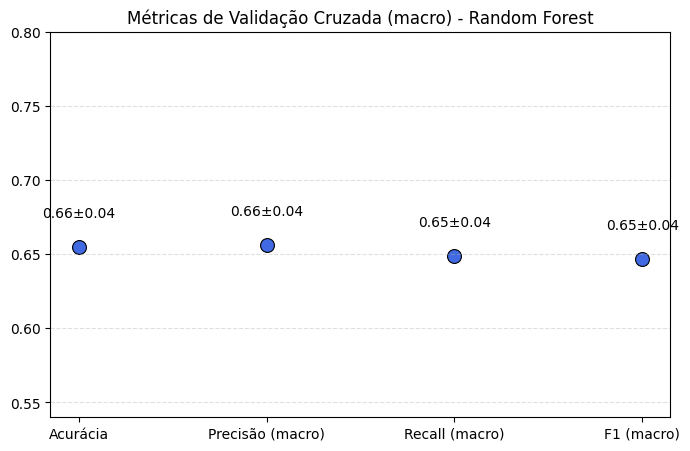

Acurácia Balanceada: 0.6483
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.5377
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.60,0.60,0.60,250.00
Q2,0.67,0.63,0.65,265.00
Q3,0.64,0.58,0.61,253.00
Q4,0.70,0.77,0.73,310.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.65,0.65,0.65,1078.00
weighted avg,0.65,0.65,0.65,1078.00


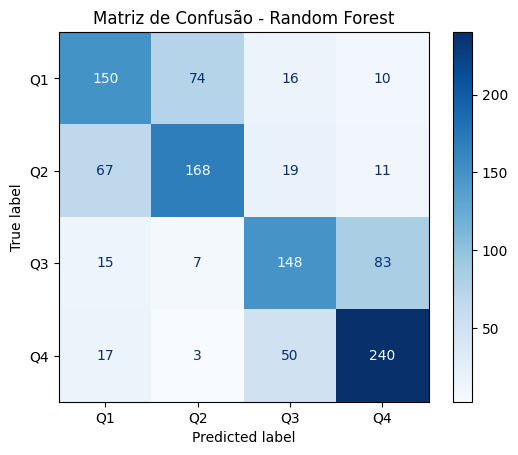

In [13]:
avaliar_e_plotar('Random Forest', modelos['Random Forest'], X_scaled, y_encoded, cv, label_encoder)

=== Random Forest - SMOTE ===


,Média,Desvio
Acurácia,0.6541,0.0403
Precisão (macro),0.6554,0.0399
Recall (macro),0.6496,0.0397
F1 (macro),0.6478,0.0409


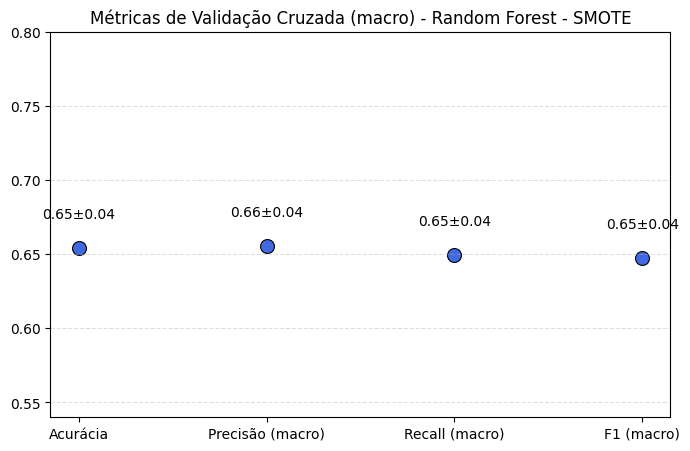

Acurácia Balanceada: 0.6494
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.5372
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.60,0.60,0.60,250.00
Q2,0.68,0.63,0.65,265.00
Q3,0.61,0.63,0.62,253.00
Q4,0.71,0.74,0.73,310.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.65,0.65,0.65,1078.00
weighted avg,0.65,0.65,0.65,1078.00


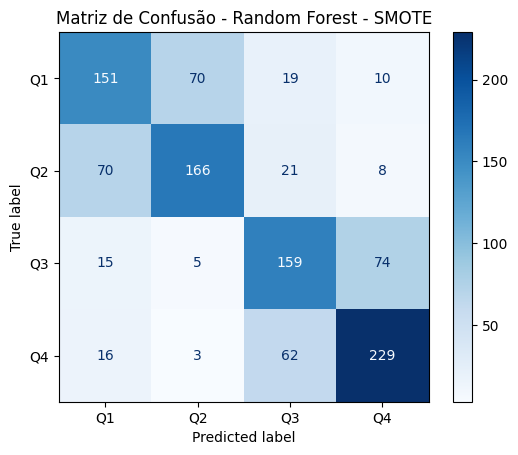

In [14]:
# COM SMOTE
avaliar_e_plotar('Random Forest - SMOTE', modelos['Random Forest'], X_scaled, y_encoded, cv, label_encoder, True)

### MLP

=== MLP ===


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

,Média,Desvio
Acurácia,0.6429,0.0561
Precisão (macro),0.6467,0.0584
Recall (macro),0.6395,0.0549
F1 (macro),0.6379,0.0566


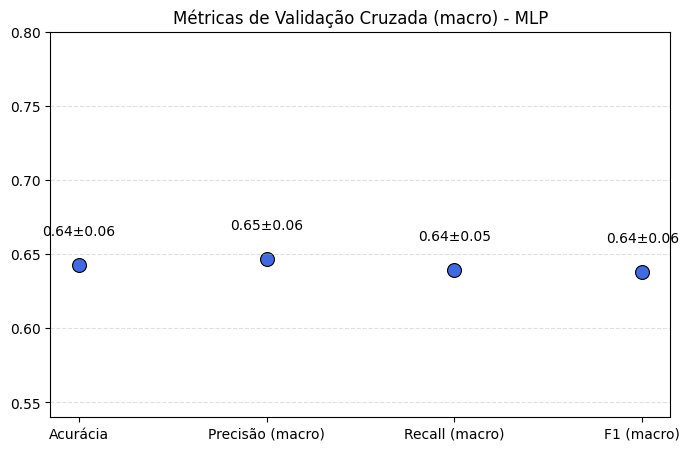

Acurácia Balanceada: 0.6391
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.5222
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.59,0.66,0.62,250.00
Q2,0.69,0.60,0.64,265.00
Q3,0.61,0.58,0.59,253.00
Q4,0.68,0.72,0.70,310.00
accuracy,0.64,0.64,0.64,0.64
macro avg,0.64,0.64,0.64,1078.00
weighted avg,0.64,0.64,0.64,1078.00


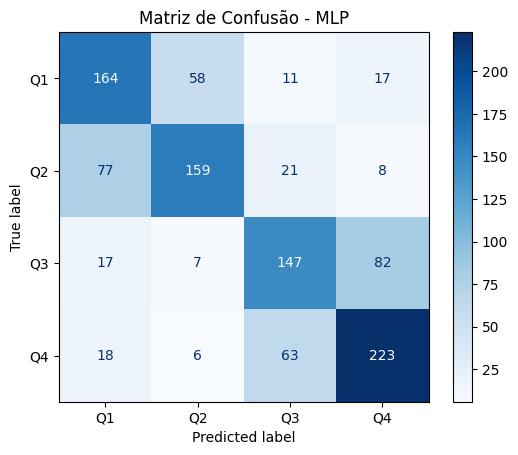

In [15]:
avaliar_e_plotar('MLP', modelos['MLP'], X_scaled, y_encoded, cv, label_encoder)

In [16]:
# com smote
#avaliar_e_plotar('MLP - SMOTE', modelos['MLP'], X_scaled, y_encoded, cv, label_encoder, True)

### KNN


=== KNN ===


,Média,Desvio
Acurácia,0.6188,0.0461
Precisão (macro),0.6343,0.0512
Recall (macro),0.6088,0.0473
F1 (macro),0.6022,0.0498


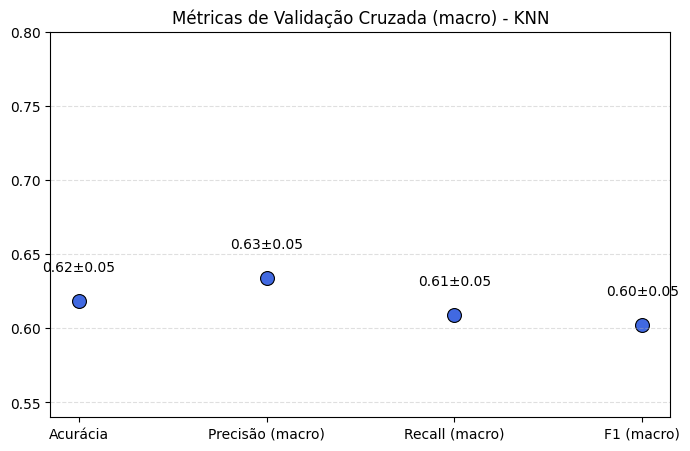

Acurácia Balanceada: 0.6087
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.4874
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.56,0.68,0.61,250.00
Q2,0.70,0.53,0.60,265.00
Q3,0.65,0.40,0.50,253.00
Q4,0.61,0.82,0.70,310.00
accuracy,0.62,0.62,0.62,0.62
macro avg,0.63,0.61,0.60,1078.00
weighted avg,0.63,0.62,0.61,1078.00


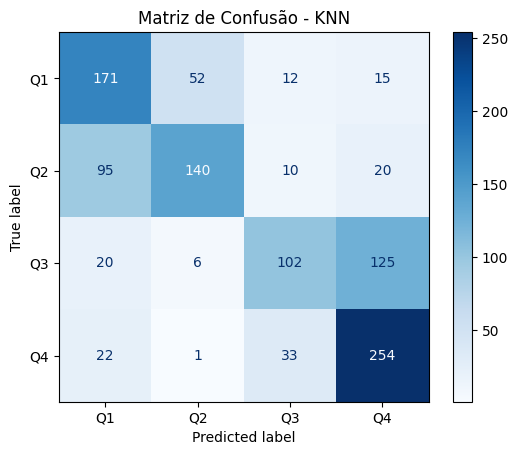

In [17]:
avaliar_e_plotar('KNN', modelos['KNN'], X_scaled, y_encoded, cv, label_encoder)

In [18]:
# com smote
# avaliar_e_plotar('KNN - SMOTE', modelos['KNN'], X_scaled, y_encoded, cv, label_encoder, True)

### Regressao Logistica

=== Logistic Regression ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

,Média,Desvio
Acurácia,0.5910,0.0556
Precisão (macro),0.5929,0.0592
Recall (macro),0.5880,0.0581
F1 (macro),0.5855,0.0588


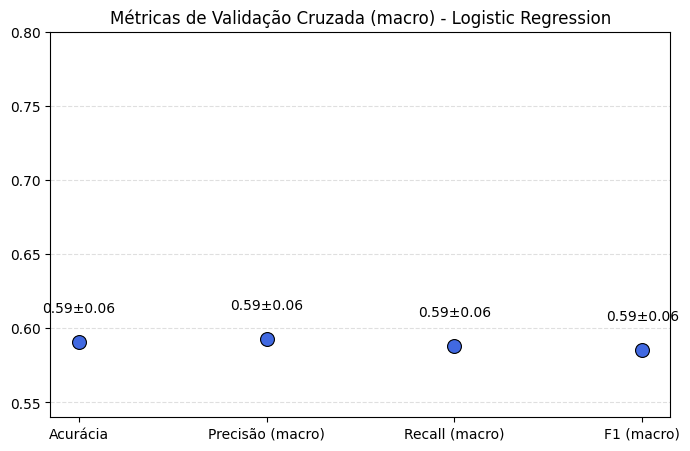

Acurácia Balanceada: 0.5879
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.4530
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.57,0.57,0.57,250.00
Q2,0.63,0.63,0.63,265.00
Q3,0.52,0.52,0.52,253.00
Q4,0.63,0.64,0.63,310.00
accuracy,0.59,0.59,0.59,0.59
macro avg,0.59,0.59,0.59,1078.00
weighted avg,0.59,0.59,0.59,1078.00


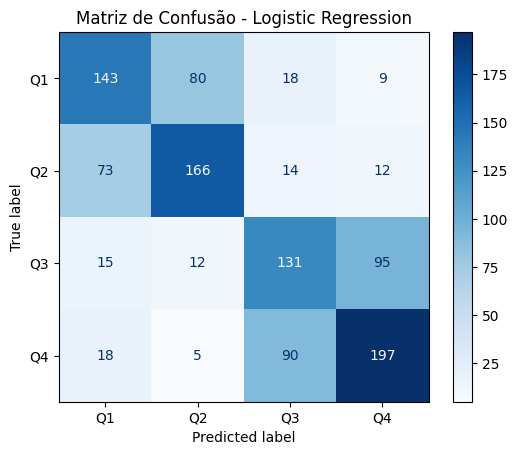

In [19]:
avaliar_e_plotar('Logistic Regression', modelos['Logistic Regression'], X_scaled, y_encoded, cv, label_encoder)

In [20]:
#com SMOTE
#avaliar_e_plotar('Logistic Regression - SMOTE', modelos['Logistic Regression'], X_scaled, y_encoded, cv, label_encoder, True)

### Naive Bayes

=== Naive Bayes ===


,Média,Desvio
Acurácia,0.5910,0.0311
Precisão (macro),0.5960,0.0341
Recall (macro),0.5792,0.0321
F1 (macro),0.5746,0.0328


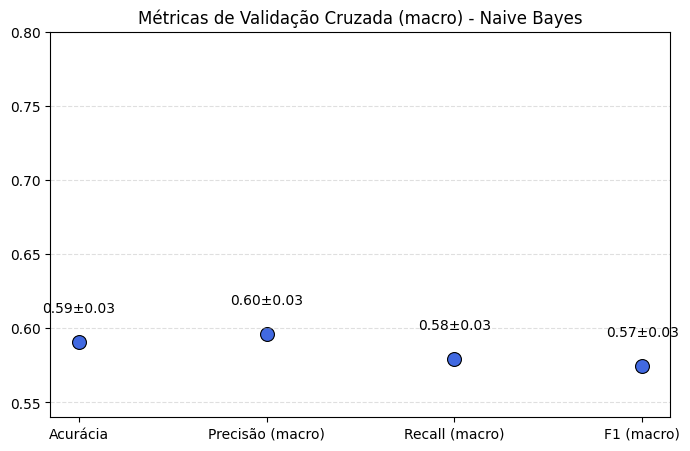

Acurácia Balanceada: 0.5793
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.4491
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.54,0.56,0.55,250.00
Q2,0.65,0.55,0.60,265.00
Q3,0.62,0.40,0.48,253.00
Q4,0.58,0.80,0.67,310.00
accuracy,0.59,0.59,0.59,0.59
macro avg,0.60,0.58,0.58,1078.00
weighted avg,0.60,0.59,0.58,1078.00


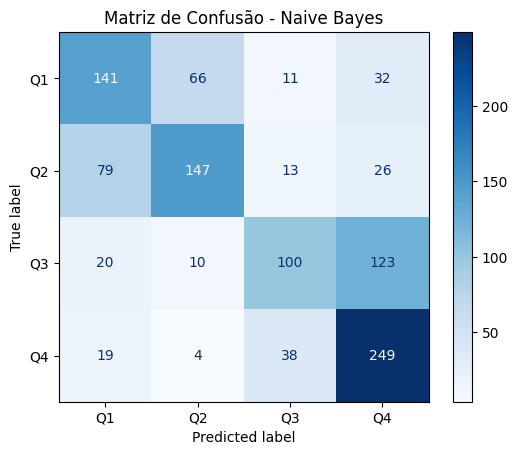

In [21]:
avaliar_e_plotar('Naive Bayes', modelos['Naive Bayes'], X_scaled, y_encoded, cv, label_encoder)

In [22]:
#com SMOTE
#avaliar_e_plotar('Naive Bayes - SMOTE', modelos['Naive Bayes'], X_scaled, y_encoded, cv, label_encoder, True)

### Gradient Boosting

=== Gradient Boosting ===


,Média,Desvio
Acurácia,0.6300,0.0506
Precisão (macro),0.6305,0.0526
Recall (macro),0.6255,0.0505
F1 (macro),0.6231,0.0504


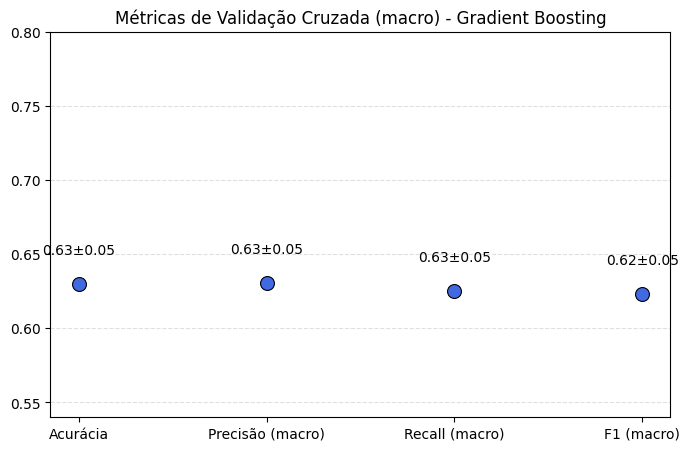

Acurácia Balanceada: 0.6251
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.5048
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.59,0.60,0.59,250.00
Q2,0.63,0.63,0.63,265.00
Q3,0.59,0.56,0.57,253.00
Q4,0.69,0.71,0.70,310.00
accuracy,0.63,0.63,0.63,0.63
macro avg,0.63,0.63,0.63,1078.00
weighted avg,0.63,0.63,0.63,1078.00


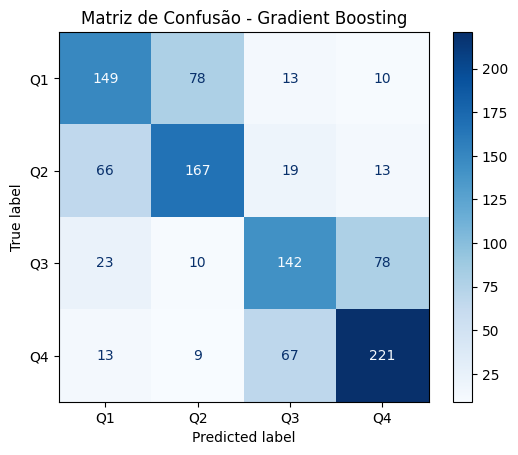

In [23]:
avaliar_e_plotar('Gradient Boosting', modelos['Gradient Boosting'], X_scaled, y_encoded, cv, label_encoder)

=== Gradient Boosting - SMOTE ===


,Média,Desvio
Acurácia,0.6420,0.0464
Precisão (macro),0.6436,0.0487
Recall (macro),0.6376,0.0469
F1 (macro),0.6363,0.0459


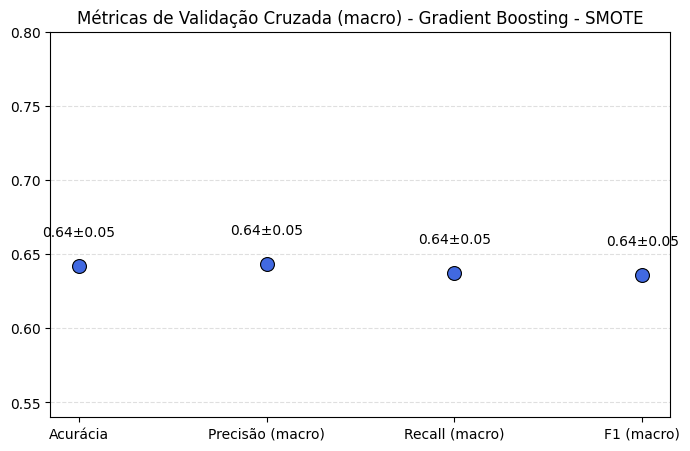

Acurácia Balanceada: 0.6373
Média aritmética do Recall de cada classe (dados desbalanceados)

Cohen's Kappa: 0.5211
Mede a concordância entre as previsões e os rótulos verdadeiros, ajustado para o acaso.



,precision,recall,f1-score,support
Q1,0.60,0.59,0.60,250.00
Q2,0.64,0.62,0.63,265.00
Q3,0.60,0.61,0.60,253.00
Q4,0.71,0.73,0.72,310.00
accuracy,0.64,0.64,0.64,0.64
macro avg,0.64,0.64,0.64,1078.00
weighted avg,0.64,0.64,0.64,1078.00


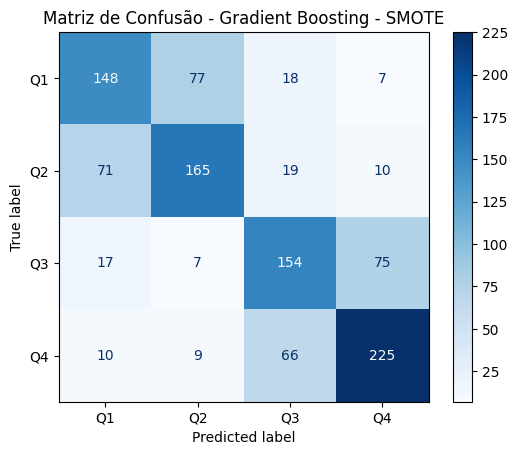

In [24]:
# COM SMOTE
avaliar_e_plotar('Gradient Boosting - SMOTE', modelos['Gradient Boosting'], X_scaled, y_encoded, cv, label_encoder, True)

In [25]:
def gerar_resumo_metricas(modelos_avaliados, X, y, cv, label_encoder):
    resumo = []

    for nome, modelo in modelos_avaliados.items():
        #print(f"Avaliando {nome}...")

        try:
            resultados = cross_validate(modelo, X, y, cv=cv, scoring=['f1_macro'], return_train_score=False)
            f1_macro_medio = resultados['test_f1_macro'].mean()

            y_pred = cross_val_predict(modelo, X, y, cv=cv)
            acc_bal = balanced_accuracy_score(y, y_pred)
            kappa = cohen_kappa_score(y, y_pred)

            resumo.append({
                'Modelo': nome,
                'F1 macro': f1_macro_medio,
                'Acurácia balanceada': acc_bal,
                'Kappa': kappa
            })
        except Exception as e:
            print(f"Erro ao avaliar {nome}: {str(e)}")
            resumo.append({
                'Modelo': nome,
                'F1 macro': None,
                'Acurácia balanceada': None,
                'Kappa': None
            })

    df_resumo = pd.DataFrame(resumo)

    numeric_cols = ['F1 macro', 'Acurácia balanceada', 'Kappa']
    for col in numeric_cols:
        df_resumo[col] = pd.to_numeric(df_resumo[col], errors='coerce')

    df_resumo = df_resumo.sort_values(by='F1 macro', ascending=False)


    styled_df = (
        df_resumo
        .style
        .background_gradient(cmap='Blues', subset=numeric_cols)
        .set_caption("Resumo das Métricas dos Modelos")
        .format("{:.4f}", subset=numeric_cols)
        .format("{}", subset=['Modelo'])
    )

    display(styled_df)
    return df_resumo

In [26]:
resumo_metricas = gerar_resumo_metricas(modelos, X_scaled, y_encoded, cv, label_encoder)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

,Modelo,F1 macro,Acurácia balanceada,Kappa
1,Random Forest,0.6466,0.6483,0.5377
2,MLP,0.6379,0.6391,0.5222
0,SVM,0.6350,0.6382,0.5227
6,Gradient Boosting,0.6231,0.6251,0.5048
3,KNN,0.6022,0.6087,0.4874
4,Logistic Regression,0.5855,0.5879,0.4530
5,Naive Bayes,0.5746,0.5793,0.4491


# Análise da Relevância das Features (Importância das Características)

## **quais características das músicas MIDI são mais cruciais para prever a emoção?**


Usar permutation_importance do scikit-learn

Esta técnica é compatível com qualquer modelo treinado e mede a mudança na performance quando uma feature é embaralhada, indicando sua importância.

* RANDOM FOREST apresentou melhor F1 macro, Acurácia balanceada e Kappa

In [27]:
# RANDOM FOREST FOI O MELHOR MODELO

melhor_modelo = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=30)
melhor_modelo.fit(X_scaled, y_encoded)


RandomForestClassifier(max_depth=30, n_estimators=250, random_state=42)

In [28]:
resultado_importancia = permutation_importance(
    melhor_modelo, X_scaled, y_encoded,
    n_repeats=50, random_state=42, scoring='f1_macro'
)


## GRAFICOS

In [ ]:
def plot_importance_interativo(result, feature_names, model_name, top_n=10):
    sorted_idx = result.importances_mean.argsort()[::-1]
    top_features = np.array(feature_names)[sorted_idx][:top_n]
    top_importances = result.importances_mean[sorted_idx][:top_n]
    top_errors = result.importances_std[sorted_idx][:top_n]

    # Cria o gráfico interativo
    fig = go.Figure(data=[
        go.Bar(
            x=top_features,
            y=top_importances,
            error_y=dict(type='data', array=top_errors, visible=True),
            marker_color='cornflowerblue',
            customdata=np.array(top_errors).reshape(-1, 1),
            hovertemplate='<b>%{x}</b><br>Importância média: %{y:.4f}<br>Desvio: %{customdata[0]:.4f}<extra></extra>'
        )
    ])

    fig.update_layout(
        title=f'Importância das Features (Permutation Importance) - {model_name}',
        xaxis_title='Feature',
        yaxis_title='Importância média (impacto no F1 macro)',
        xaxis_tickangle=-45,
        template='plotly_white',
        height=500
    )

    fig.show()


In [ ]:
plot_importance_interativo(
    resultado_importancia,
    features_df.drop(columns=['music_name', 'emotion_quadrant']).columns,
    'Random Forest',
    top_n=14
)


### % da importancia

In [29]:
def plot_importance_estatico(result, feature_names, model_name, top_n=10):

    importances = result.importances_mean
    importances_perc = 100 * (importances / importances.sum())

    df_plot = pd.DataFrame({
        'Feature': feature_names,
        'Importancia_%': importances_perc
    }).sort_values(by='Importancia_%', ascending=False).head(top_n)


    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot,
        y='Feature',
        x='Importancia_%',
        color='steelblue'
    )

    plt.xlabel('Importância (%)')
    plt.title(f'Importância das Features  - {model_name}')
    plt.xlim(0, df_plot['Importancia_%'].max() + 5)
    plt.tight_layout()
    plt.show()

    return df_plot


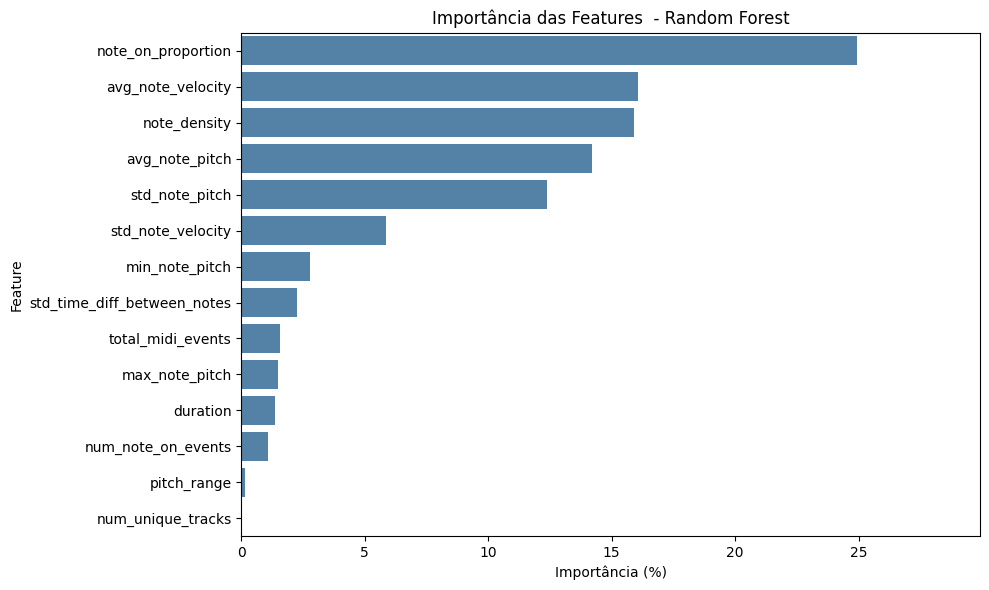

In [30]:
df_importancia_porcentagem = plot_importance_estatico(
    resultado_importancia,
    features_df.drop(columns=['music_name', 'emotion_quadrant']).columns,
    'Random Forest',
    top_n=14
)


In [33]:
def plot_importance_estatico(result, feature_names, model_name, top_n=10):
    # Mapeamento dos nomes técnicos para nomes mais intuitivos
    nomes_intuitivos = {
        'avg_note_velocity': 'Intensidade média das notas',
        'note_density': 'Densidade de notas',
        'std_note_velocity': 'Variação da intensidade',
        'note_on_proportion': 'Proporção de notas ativas',
        'avg_note_pitch': 'Altura média das notas',
        'std_note_pitch': 'Variação da altura das notas',
        'min_note_pitch': 'Nota mais grave',
        'max_note_pitch': 'Nota mais aguda',
        'pitch_range': 'Intervalo de notas',
        'duration': 'Duração da música',
        'num_note_on_events': 'Eventos note_on',
        'num_note_off_events': 'Eventos note_off',
        'total_midi_events': 'Total de eventos MIDI',
        'num_set_tempo_events': 'Mudanças de tempo',
        'num_unique_tracks': 'Trilhas únicas',
        'num_unique_channels': 'Canais únicos',
        'std_time_diff_between_notes': 'Variação do tempo entre notas'
    }

    importances = result.importances_mean
    importances_perc = 100 * (importances / importances.sum())

    # Aplica os nomes intuitivos
    nomes_legiveis = [nomes_intuitivos.get(f, f) for f in feature_names]

    df_plot = pd.DataFrame({
        'Feature': nomes_legiveis,
        'Importancia_%': importances_perc
    }).sort_values(by='Importancia_%', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot,
        y='Feature',
        x='Importancia_%',
        color='steelblue'
    )

    plt.xlabel('Importância (%)')
    plt.title(f'Importância das Features - {model_name}')
    plt.xlim(0, df_plot['Importancia_%'].max() + 5)
    plt.tight_layout()
    plt.show()

    return df_plot


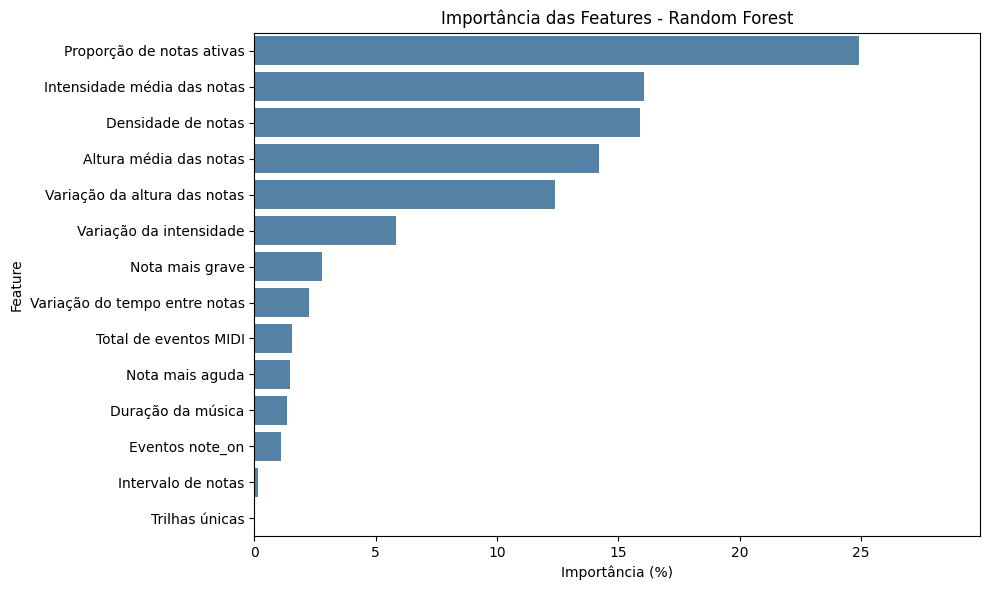

In [34]:
df_importancia_porcentagem = plot_importance_estatico(
    resultado_importancia,
    features_df.drop(columns=['music_name', 'emotion_quadrant']).columns,
    'Random Forest',
    top_n=14
)


In [ ]:
def plot_importance_estatico_acumulada(result, feature_names, model_name, top_n=10):
    importances = result.importances_mean

    df_plot = pd.DataFrame({
        'Feature': feature_names,
        'Importancia_%': importances
    }).sort_values(by='Importancia_%', ascending=False).head(top_n).reset_index(drop=True)


    df_plot['Importancia_%_Normalizada'] = 100 * (df_plot['Importancia_%'] / df_plot['Importancia_%'].sum())
    df_plot['Importancia_Acumulada_%'] = df_plot['Importancia_%_Normalizada'].cumsum()

    plt.figure(figsize=(12, 7))


    ax1 = plt.gca()


    sns.barplot(
        data=df_plot,
        y='Feature',
        x='Importancia_%_Normalizada',
        color='steelblue',
        ax=ax1
    )

    ax1.set_xlabel('Importância Relativa (%)')
    ax1.set_title(f'Importância das Features - {model_name}')
    ax1.set_xlim(0, df_plot['Importancia_%_Normalizada'].max() * 1.1)
    ax1.grid(axis='x', linestyle='--', alpha=0.6, color='lightgray')


    ax2 = ax1.twiny()


    ax2.plot(df_plot['Importancia_Acumulada_%'], df_plot.index, color='blue', marker='o', linestyle='-', linewidth=2, label='Importância Acumulada (%)')

    ax2.set_xlabel('Importância Acumulada (%)', color='blue')
    ax2.tick_params(axis='x', labelcolor='blue')
    ax2.set_xlim(0, 100)
    ax2.grid(axis='x', linestyle=':', alpha=0.4, color='blue')


    #ax1.legend(['Importância Relativa'], loc='lower right')
    #ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    return df_plot

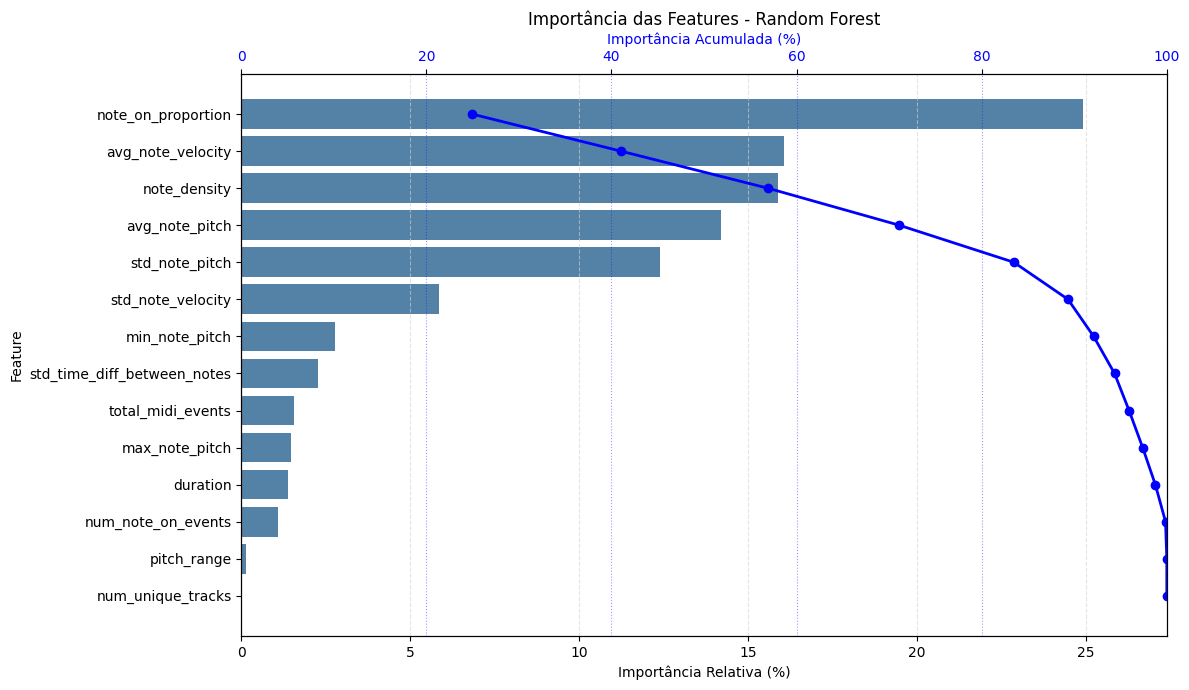

In [ ]:
df_importancia_porcentagem = plot_importance_estatico_acumulada(
    resultado_importancia,
    features_df.drop(columns=['music_name', 'emotion_quadrant']).columns,
    'Random Forest',
    top_n=14
)


In [ ]:
def plot_importance_dots(result, feature_names, model_name, top_n=10):
    importances = result.importances_mean
    importances_perc = 100 * (importances / importances.sum())


    df_plot = pd.DataFrame({
        'Feature': feature_names,
        'Importancia_%': importances_perc
    }).sort_values(by='Importancia_%', ascending=False).head(top_n)


    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_plot,
        y='Feature',
        x='Importancia_%',
        color='steelblue',
        s=100,
        zorder=3

    )

    plt.xlabel('Importância (%)')
    plt.title(f'Importância das Features - {model_name}')
    plt.xlim(5, df_plot['Importancia_%'].max() + 5)


    plt.grid(True, linestyle='--', alpha=0.6, color='lightgray')

    plt.tight_layout()
    plt.show()

    return df_plot

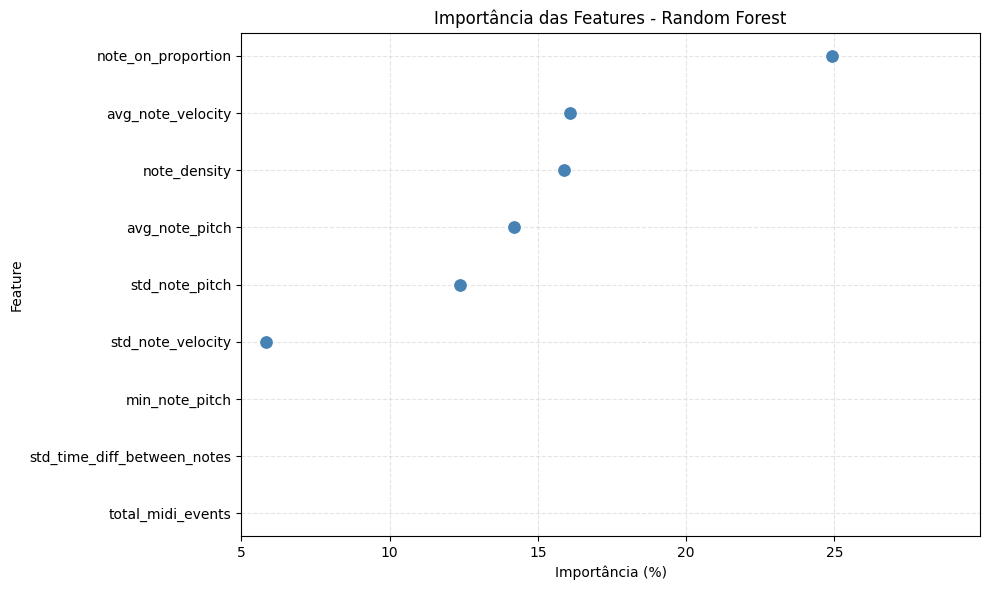

In [ ]:
df_importancia_dots = plot_importance_dots(
    resultado_importancia,
    features_df.drop(columns=['music_name', 'emotion_quadrant']).columns,
    'Random Forest',
    top_n=9
)


# SHAP

- Calcula a contribuição de cada feature para cada predição individual

- Dá explicações locais (por amostra) e globais (média das contribuições)

- É considerado um dos métodos mais rigorosos e matematicamente sólidos para interpretar modelos complexos como Gradient Boosting, MLP, etc

- Ir além da importância média das features e entender a variação da influência por amostra

* Eixo X:
  - mean(|SHAP value|) → impacto médio (em módulo) daquela feature na decisão do modelo, para qualquer classe (emoção).
  - Quanto mais à direita, maior a importância dessa feature para o modelo.

*  Cores (Q1, Q2, Q3, Q4):
  - Indicam o impacto médio da feature em cada classe (emoção) no conjunto de dados.

* Por exemplo:
  - avg_note_velocity teve um grande impacto médio nas previsões, especialmente para Q1

In [ ]:
!pip install shap
import shap

In [ ]:
explainer = shap.Explainer(melhor_modelo, X_scaled)
shap_values = explainer(X_scaled, check_additivity=False)
# shap_values = explainer(X_scaled)

100%|===================| 4310/4312 [05:35<00:00]       

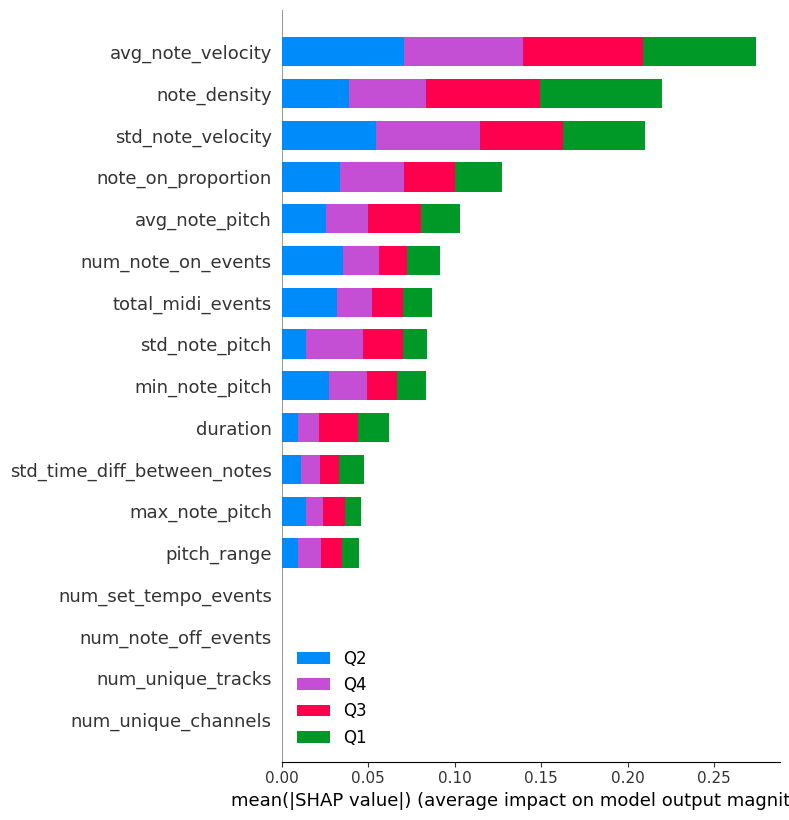

In [ ]:
#shap.summary_plot(shap_values, X_scaled, feature_names=features_df.drop(columns=['music_name', 'emotion_quadrant']).columns)
#cores = sns.color_palette("colorblind", 4)

shap.summary_plot(
    shap_values,
    X_scaled,
    feature_names=features_df.drop(columns=['music_name', 'emotion_quadrant']).columns,
    class_names=["Q1", "Q2", "Q3", "Q4"]
    #color = cores
)


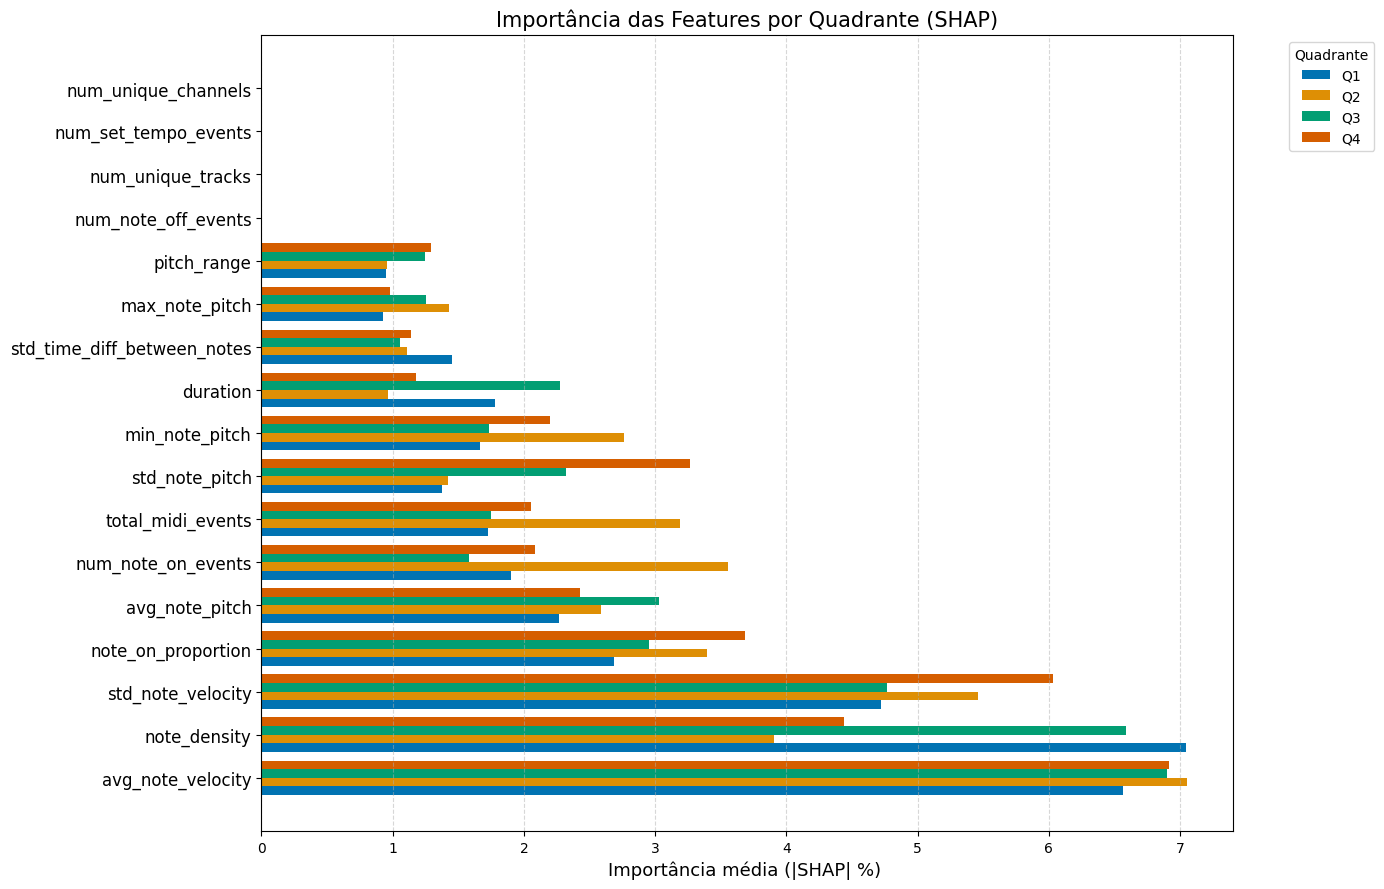

In [ ]:
plt.figure(figsize=(14, 9))

cores = sns.color_palette("colorblind", 4)

largura = 0.2
posicoes = np.arange(len(ordem_features))

for i, classe in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    valores = df_plot[df_plot['Classe'] == classe].set_index('Feature').loc[ordem_features]['SHAP'] * 100
    plt.barh(posicoes + i * largura, valores, height=largura, label=classe, color=cores[i])

plt.yticks(posicoes + 1.5 * largura, ordem_features, fontsize=12)
plt.xlabel('Importância média (|SHAP| %) ', fontsize=13)
plt.title('Importância das Features por Quadrante (SHAP)', fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(title='Quadrante', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
